In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

torch.manual_seed(1)

In [2]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# define corpus
corpus = [
    'he is a king',
    'she is a queen',
    'he is a man',
    'she is a woman',
    'warsaw is poland capital',
    'berlin is germany capital',
    'paris is france capital',
]

In [4]:
# step1. creating vocabulary

# tokenize sentences
def tokenize_corpus(corpus):
    tokens = [sentence.split() for sentence in corpus]
    return tokens

tokenized_corpus = tokenize_corpus(corpus)

print("tokenized corpus:", tokenized_corpus)

# word->idx, idx->word
word2idx = {}
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in word2idx:
            word2idx[token] = len(word2idx)

idx2word = {v: k for k, v in word2idx.items()}

print("word2idx:", word2idx)
print("idx2word:", idx2word)

word_vocab_size = len(word2idx)

tokenized corpus: [['he', 'is', 'a', 'king'], ['she', 'is', 'a', 'queen'], ['he', 'is', 'a', 'man'], ['she', 'is', 'a', 'woman'], ['warsaw', 'is', 'poland', 'capital'], ['berlin', 'is', 'germany', 'capital'], ['paris', 'is', 'france', 'capital']]
word2idx: {'he': 0, 'is': 1, 'a': 2, 'king': 3, 'she': 4, 'queen': 5, 'man': 6, 'woman': 7, 'warsaw': 8, 'poland': 9, 'capital': 10, 'berlin': 11, 'germany': 12, 'paris': 13, 'france': 14}
idx2word: {0: 'he', 1: 'is', 2: 'a', 3: 'king', 4: 'she', 5: 'queen', 6: 'man', 7: 'woman', 8: 'warsaw', 9: 'poland', 10: 'capital', 11: 'berlin', 12: 'germany', 13: 'paris', 14: 'france'}


In [5]:
# step 2. Generate pairs (center word - context word)
window_size = 2
idx_pairs = []

# for each sentence
for sentence in tokenized_corpus:
    word_idxs = [word2idx[word] for word in sentence]
    for center_word_pos in range(len(word_idxs)):
        for context_word_pos in range(len(word_idxs)):
            if center_word_pos == context_word_pos:
                pass
            else:
                idx_pairs.append((word_idxs[center_word_pos], word_idxs[context_word_pos]))
idx_pairs = np.array(idx_pairs)
print(idx_pairs.shape)

(84, 2)


## Defining goal
@ We want to predict context, given center word and soma parametrization.

@ We are making P(context | center) close to 0 for all non-existing (context, center) pairs.

In [6]:
# input layer: just the center word encoded in one-hot manner.
def get_one_hot(word_idx, word_vocab_size):
    x = torch.zeros(word_vocab_size).float()
    x[word_idx] = 1.0
    return x

In [7]:
embedding_dim = 5

W1 = torch.randn((word_vocab_size, embedding_dim), requires_grad=True).to(device)
W2 = torch.randn((embedding_dim, word_vocab_size), requires_grad=True).to(device)

num_epochs = 500
lr = 0.01

print(W1)
print(W2)

tensor([[-1.5256, -0.7502, -0.6540, -1.6095, -0.1002],
        [-0.6092, -0.9798, -1.6091, -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  1.6871,  0.2284],
        [ 0.4676, -0.6970, -1.1608,  0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  0.8073,  1.1017],
        [-0.1759, -2.2456, -1.4465,  0.0612, -0.6177],
        [-0.7981, -0.1316,  1.8793, -0.0721,  0.1578],
        [-0.7735,  0.1991,  0.0457,  0.1530, -0.4757],
        [-0.1110,  0.2927, -0.1578, -0.0288,  2.3571],
        [-1.0373,  1.5748, -0.6298, -0.9274,  0.5451],
        [ 0.0663, -0.4370,  0.7626,  0.4415,  1.1651],
        [ 2.0154,  0.1374,  0.9386, -0.1860, -1.1802],
        [ 0.4100,  0.4085,  0.2579,  1.0950, -0.5065],
        [ 0.0998, -0.6540,  0.7000, -1.4567,  1.6089],
        [ 0.0938, -1.2597,  0.2546, -0.5020, -1.0412]])
tensor([[-0.3003,  1.3075, -1.1628,  0.1196, -0.1631,  0.6614,  1.1899,
          0.8165,  0.4208, -0.3538,  0.7639, -0.5890, -0.7636,  1.3352,
          0.6043],
        [-0

In [8]:
for epoch in range(num_epochs):
    loss_val = 0
    for center, context in idx_pairs:    
        input = get_one_hot(center, word_vocab_size).to(device).float()
        target = torch.from_numpy(np.array([context])).to(device).long()
        w1_out = torch.matmul(input, W1)
        w2_out = torch.matmul(w1_out, W2)
        
        log_softmax = F.log_softmax(w2_out, dim=0).view(1, -1)
            
        loss = F.nll_loss(log_softmax, target)
        loss_val += loss.item()
        loss.backward()
        
        W1.data -= lr * W1.grad.data
        W2.data -= lr * W2.grad.data
        
        W1.grad.data.zero_()
        W2.grad.data.zero_()
    
    if epoch % 10 == 0:
        print("[%d/%d] loss:%.3f" % (epoch+1, num_epochs, loss_val / float(len(idx_pairs))))
        

[1/500] loss:4.220
[11/500] loss:2.865
[21/500] loss:2.559
[31/500] loss:2.398
[41/500] loss:2.284
[51/500] loss:2.198
[61/500] loss:2.133
[71/500] loss:2.084
[81/500] loss:2.044
[91/500] loss:2.012
[101/500] loss:1.984
[111/500] loss:1.960
[121/500] loss:1.939
[131/500] loss:1.920
[141/500] loss:1.904
[151/500] loss:1.890
[161/500] loss:1.877
[171/500] loss:1.866
[181/500] loss:1.856
[191/500] loss:1.848
[201/500] loss:1.840
[211/500] loss:1.833
[221/500] loss:1.827
[231/500] loss:1.822
[241/500] loss:1.818
[251/500] loss:1.814
[261/500] loss:1.810
[271/500] loss:1.806
[281/500] loss:1.803
[291/500] loss:1.801
[301/500] loss:1.798
[311/500] loss:1.795
[321/500] loss:1.793
[331/500] loss:1.791
[341/500] loss:1.789
[351/500] loss:1.787
[361/500] loss:1.785
[371/500] loss:1.783
[381/500] loss:1.782
[391/500] loss:1.780
[401/500] loss:1.778
[411/500] loss:1.777
[421/500] loss:1.775
[431/500] loss:1.774
[441/500] loss:1.773
[451/500] loss:1.771
[461/500] loss:1.770
[471/500] loss:1.769
[48

In [9]:
print("After training:")

print("W1:", W1)
print(W1.shape)
print("W2:", W2)
print(W2.shape)


After training:
W1: tensor([[-1.7835,  0.1153, -0.2252, -2.5969, -1.0870],
        [ 0.1578, -0.2269, -0.4201,  0.7910, -0.6297],
        [-1.9548, -0.0257,  1.1929, -0.7249,  1.2230],
        [-1.6002, -0.6978, -1.2067, -0.4119,  1.0497],
        [-0.8469,  0.6052, -2.2162, -0.0482,  2.0459],
        [-1.0170, -2.2390, -1.4882, -0.7445,  0.0791],
        [-2.5230, -0.2487, -0.8399, -1.0116,  1.0249],
        [-1.4735, -1.6889, -1.0667, -0.8655,  0.2084],
        [ 1.0330, -1.0755,  0.8461,  0.3181,  2.5823],
        [ 1.6674,  0.2928, -1.8276, -0.7863,  0.7856],
        [ 1.1310,  0.8380,  1.3122, -1.1376,  0.7753],
        [ 2.3192, -1.1896,  0.6457, -1.9716, -0.5290],
        [ 1.1719, -1.7593,  1.2055, -0.8463,  0.4476],
        [ 1.9922,  0.4902, -0.3552, -0.1955,  2.4133],
        [ 1.6021, -0.8729, -1.0631, -1.6164, -0.8250]])
torch.Size([15, 5])
W2: tensor([[-1.9577,  0.3646, -1.5099, -1.0916, -1.3976, -0.9445, -1.2504,
         -0.8774,  1.6550,  1.3349,  2.9809,  1.3457,  1.7

In [10]:
input = idx_pairs[0][0]
target = idx_pairs[0][1]

print("Test input:", idx2word[input])

input = get_one_hot(input, word_vocab_size)
w1_out = torch.matmul(input, W1)
w2_out = torch.matmul(w1_out, W2)
log_softmax = F.log_softmax(w2_out, dim=0).view(1, -1)    

sorted = np.argsort(log_softmax.data[0]).numpy()

print("Test output:", end=' ')
for idx in sorted[::-1]:
    print(idx2word[idx], end=', ')

Test input: he
Test output: a, is, man, king, he, she, paris, germany, warsaw, queen, woman, berlin, poland, france, capital, 

In [11]:
all_dict = {}
for idx in range(len(word2idx)):
    word_pair = []
    for center, context in idx_pairs:
        if idx == center:
            word_pair.append(idx2word[context])
    all_dict[idx2word[idx]] = set(word_pair)
    
print(all_dict)

{'he': {'man', 'a', 'king', 'is'}, 'is': {'she', 'queen', 'poland', 'germany', 'warsaw', 'berlin', 'he', 'king', 'a', 'paris', 'woman', 'man', 'france', 'capital'}, 'a': {'she', 'queen', 'he', 'king', 'woman', 'man', 'is'}, 'king': {'he', 'is', 'a'}, 'she': {'queen', 'a', 'is', 'woman'}, 'queen': {'a', 'she', 'is'}, 'man': {'he', 'is', 'a'}, 'woman': {'a', 'she', 'is'}, 'warsaw': {'poland', 'is', 'capital'}, 'poland': {'is', 'capital', 'warsaw'}, 'capital': {'germany', 'poland', 'warsaw', 'berlin', 'paris', 'france', 'is'}, 'berlin': {'germany', 'is', 'capital'}, 'germany': {'berlin', 'is', 'capital'}, 'paris': {'france', 'is', 'capital'}, 'france': {'is', 'capital', 'paris'}}


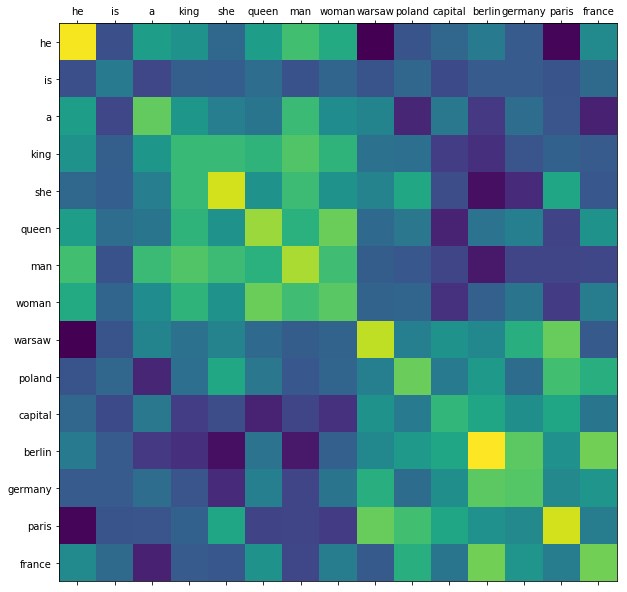

In [13]:
# If i choose W2
# plotting correlation matrix
# lighter color => more related

import matplotlib.pyplot as plt

corr = torch.matmul(W1, W1.permute(1, 0)).detach().numpy()
plt.figure(figsize=(10, 10))
plt.matshow(corr, fignum=1)

groups = list(word2idx.keys())

x_pos = np.arange(len(groups))
plt.xticks(x_pos, groups)

y_pos = np.arange(len(groups))
plt.yticks(y_pos, groups)

plt.show()

['he', 'is', 'a', 'king', 'she', 'queen', 'man', 'woman', 'warsaw', 'poland', 'capital', 'berlin', 'germany', 'paris', 'france']


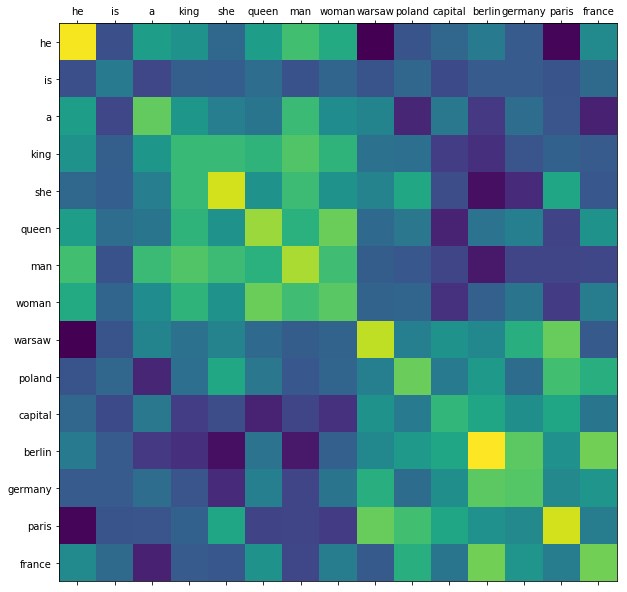

In [17]:
# If I choose W1
corr = torch.matmul(W1, W1.permute(1, 0)).detach().numpy()
plt.figure(figsize=(10, 10))
plt.matshow(corr, fignum=1)

groups = list(word2idx.keys())
print(groups)

x_pos = np.arange(len(groups))
plt.xticks(x_pos, groups)

y_pos = np.arange(len(groups))
plt.yticks(y_pos, groups)

plt.show()

torch.Size([15, 15])


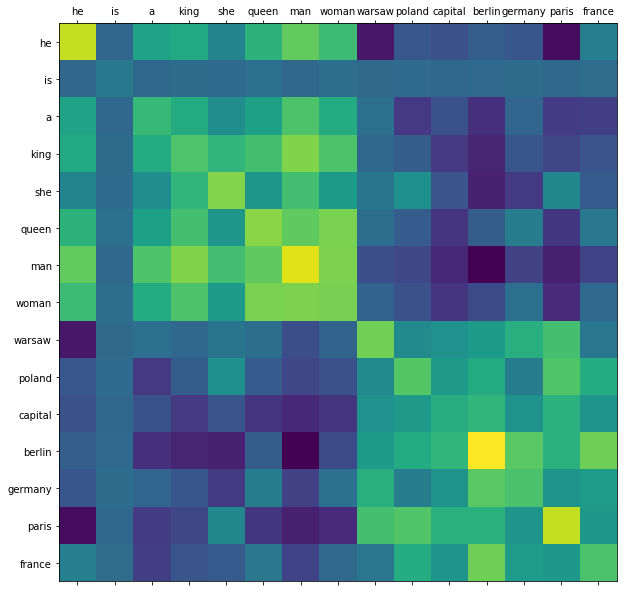

In [15]:
total = torch.matmul(W1, W2)
print(total.shape)
corr = torch.matmul(total, total.permute(1, 0)).detach().numpy()
plt.figure(figsize=(10, 10))
plt.matshow(corr, fignum=1)

groups = list(word2idx.keys())

x_pos = np.arange(len(groups))
plt.xticks(x_pos, groups)

y_pos = np.arange(len(groups))
plt.yticks(y_pos, groups)

plt.show()

In [16]:
from tensorboardX import SummaryWriter

In [22]:
writer = SummaryWriter("C:\\Users\\young\\Desktop\\tbx")
writer.add_embedding(W1, metadata=groups)
writer.close()

### Result embedding graph using tensorboard

![](07_tensorboard.PNG)